# Tiltmeter - Calibration - Test Run 3

### Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from andbro__readYaml import __readYaml
from andbro__get_seconds import __get_seconds
''
from scipy import signal
from obspy import UTCDateTime, read


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

''

### Methods

In [2]:
def __removeLinearTrend(data):

    for i in range(2):
        N = data[i].stats.npts
        m = (data[i].data[-1] - data[i].data[0]) / (data[i].stats.delta * N)
        data[i].data = data[i].data - np.arange(0, N) * m
    return data

In [3]:
def __remove_nan_values(st):
    idx = []
    [idx.append(i) for i, value in enumerate(st[0].data) if not np.isnan(value)]
    st[0].data  = np.array([st[0].data[j] for j in idx])
    st[1].data  = np.array([st[1].data[j] for j in idx])
    st[2].data  = np.array([st[2].data[j] for j in idx])
    
    return st

In [4]:
def __smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [27]:
def __makeplot_calibration(st, slopes, intercepts, tf, setT=None, derive=None, poly=None, smooth=None, coeff=None):
    
    if derive:
        x_temp = np.gradient(st[2].data, 2)
    else:
        x_temp = st[2].data     
        
        
    if smooth:
        x_temp = __smooth(x_temp, smooth)

    ## adjust time axis
    diff = 86400
    
    
    fig, ax = plt.subplots(3, 2, figsize=(15,10))

    plt.subplots_adjust(hspace=0.3)
    
    ax[0][0].plot(st[0].times()/diff, st[2].data, label="Temp")
        
    ax[0][0].plot(tf['Seconds']/diff, tf['Temperature (°C)'])
    
    if setT is not None:  
        
        ax[0][0].plot(setT['Seconds']/diff, setT['Temperature'])

        
    if derive:
        axes1 = ax[0][0].twinx()
        axes1.plot(st[0].times()/diff, x_temp, 'g', label="dT/dt")
    
    ax[0][1].plot(st[0].times()/diff, st[2].data, label="Temp")

        
    
    if derive:
        axes2 = ax[0][1].twinx()
        axes2.plot(st[0].times()/diff, x_temp, 'g', label="dT/dt")
    
    for i in range(2):
        
        ax[1][i].plot(x_temp, st[i].data, 'k.', ms=0.2)

        if not poly:        
            ax[1][i].plot(x_temp, slopes[i]*x_temp + intercepts[i], 'r', label=f"{slopes[i]:.2e}*x")
            
#             correction = slopes[i] * x_temp + intercepts[i]
            correction = slopes[i] * x_temp
            
            ax[2][i].plot(st[i].times()/diff, st[i].data - correction, label="corrected", zorder=2)
            ax[2][i].plot(st[i].times()/diff, st[i].data, color='grey', alpha=0.5, label="observed")

        else: 
            ax[1][i].plot(x_temp, ffit[i], 'r')
            ax[2][i].plot(st[i].times()/diff, st[i].data - poly[i], label="corrected", zorder=2)
            ax[2][i].plot(st[i].times()/diff, st[i].data - coeff[i][0], color='grey', alpha=0.5, label="observed")
            
    ax[0][0].set_title("Component 1")
    ax[0][1].set_title("Component 2")
    
    if derive:
        ax[1][0].set_xlabel("Derivative of Temperature (°C)")
        ax[1][1].set_xlabel("Derivative of Temperature (°C)")
    else:
        ax[1][0].set_xlabel("Temperature (°C)")
        ax[1][1].set_xlabel("Temperature (°C)")
        
    ax[0][0].set_xlabel("Time (days)")
    ax[0][1].set_xlabel("Time (days)")
    
    ax[2][0].set_xlabel("Time (days)")
    ax[2][1].set_xlabel("Time (days)")
    
    ax[0][0].set_ylabel("Temperature (°C)")
    
    ax[1][0].set_ylabel("Tilt (rad)")
    ax[2][0].set_ylabel("Tilt (rad)")

    
    ax[0][1].legend()
    ax[0][0].legend()
    ax[1][0].legend()
    ax[1][1].legend()
    ax[2][0].legend()
   
    if derive:
        axes1.legend()
        axes2.legend()
        axes2.set_ylabel("dT/dt ")
    
    plt.plot();
    return fig

### Configurations

In [6]:
## configurations
config={}

path = "/home/andbro/Desktop/tiltmeter/"

config['save'] = False

config['name'] = 'tiltmeter'

config['set_filter'] = 'n'


## tiltmeter configurations
try:
    confTilt = __readYaml('/home/brotzer/Documents/ROMY/tiltmeter/','tiltmeter_romy.conf')
    confPT = confTilt['PT']
except:
    confTilt = __readYaml('./','tiltmeter_romy.conf')
    confPT = confTilt['PT']

### Load Tilt Data

load data for the platform tiltmeter

In [7]:
name = "TestRun3_6hour_intervals"


st =  read(f"/home/brotzer/Documents/ROMY/tiltmeter/Temperature_Calibration/{name}/mseed/MAE.D/*")
st += read(f"/home/brotzer/Documents/ROMY/tiltmeter/Temperature_Calibration/{name}/mseed/MAN.D/*")
st += read(f"/home/brotzer/Documents/ROMY/tiltmeter/Temperature_Calibration/{name}/mseed/MAT.D/*")

st.merge()

## cutoff edges of tiltmeter data to avoid fast ambient adjustments
cutoff = 600 ## seconds 
st.trim(st[0].stats.starttime+cutoff, st[0].stats.endtime-cutoff);

### Load Temperature Data

In [8]:
path_to_files = f"/home/brotzer/Documents/ROMY/tiltmeter/Temperature_Calibration/{name}/"

filenames = ["BW.WROMY.WS9.D.2021.347","BW.WROMY.WS9.D.2021.348"]


## read data files
for i, filename in enumerate(filenames):
    if i == 0:
        tf = pd.read_csv(path_to_files+filename)
    else:
        tf0 = pd.read_csv(path_to_files+filename)
        tf = pd.concat([tf, tf0], ignore_index=True)

tf.reindex()
        
## adjust Seconds vector for multiple days
tf['Seconds'] = [tf['Seconds'][i] + int(str(tf['Date'][i])[-2:])*86400 for i in range(tf['Date'].size)]
tf['Seconds'] -= int(str(tf['Date'][0])[-2:])*86400

## correct for onset of tilmeter recording
tf['Seconds'] -= __get_seconds(st[0].stats.starttime, mode='of_day')

# plt.scatter(tf['Seconds'], tf['Temperature (°C)']);

,Seconds,Date,Time (UTC),Temperature (°C),Pressure (hPa),rel. Humidity (%)
0,56581,20211213,154301,9.7,961.9,69.2
1,56582,20211213,154302,9.7,961.9,69.2
2,56583,20211213,154303,9.7,962.0,69.2
3,56584,20211213,154304,9.7,962.0,69.2
4,56585,20211213,154305,9.7,962.0,69.2
...,...,...,...,...,...,...
83023,53203,20211214,144643,28.0,960.5,27.6
83024,53204,20211214,144644,28.0,960.5,27.6
83025,53205,20211214,144645,28.0,960.5,27.6
83026,53206,20211214,144646,28.0,960.5,27.6


## Set Temperature

In [9]:
def __make_set_temperature(steps, dt):
        
        temperature = np.array([])
        for i, step in enumerate(steps):
            
            if i != 0:
                slope = np.linspace(Tval, step[2], int(60/dt)) 
                temperature = np.append(temperature, slope)
            
            T = UTCDateTime(step[1])-UTCDateTime(step[0])
            data = np.ones(int(T/dt)) * step[2]
            temperature = np.append(temperature, data)
            
            Tval = step[2]
        
        totalT = UTCDateTime(steps[len(steps)-1][1]) - UTCDateTime(steps[0][0])
        taxis = np.arange(0, totalT, dt)
            
        return taxis, temperature

In [10]:
## sampling time for calibration data
dt = 10.0 ## seconds

## set intervals for calibration data manually
steps = [["2021-12-13 08:53", "2021-12-13 16:39", 10], 
         ["2021-12-13 16:40", "2021-12-14 08:32", 20],
         ["2021-12-14 08:33", "2021-12-14 14:57", 30]]


## generate calibration temperature curve
taxis, setTemperature = __make_set_temperature(steps, dt)

## reference to starttime of tiltmeter recordings
taxis -= st[0].stats.starttime - UTCDateTime(steps[0][0])

## transfer to data frame
setT = pd.DataFrame(data=None, columns = ["Seconds", "Temperature"])
setT['Seconds'] = taxis
setT['Temperature'] = setTemperature

### Convert Data

Convert data using the specifications of the tiltmeters

In [11]:
def __conversion(st, confPT):

    def convertTemp(trace, gain):
        Tvolt = trace.data * gain
        return confPT['calcTempCoefficients'][0] + confPT['calcTempCoefficients'][1] * Tvolt + confPT['calcTempCoefficients'][2] * Tvolt**2 + confPT['calcTempCoefficients'][3] * Tvolt**3    
        
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity
        # print( type(conversion), type(sensitivity), type(trace.data) )

    for tr in st:
        if tr.stats.channel == 'MAT':
            tr.data = convertTemp(tr, confPT['gainTemp'])
        elif tr.stats.channel == 'MAN':
            tr.data = convertTilt(tr, confPT['convPTN'], confPT['gainTilt'])
        elif tr.stats.channel == 'MAE':
            tr.data = convertTilt(tr, confPT['convPTE'], confPT['gainTilt'])

        elif tr.stats.channel == 'LAT':
            tr.data = convertTemp(tr, confBT['gainTemp'])
        elif tr.stats.channel == 'LAN':
            tr.data = convertTilt(tr, confBT['convBTN'], confBT['gainTilt'])
        elif tr.stats.channel == 'LAE':
            tr.data = convertTilt(tr, confBT['convBTE'], confBT['gainTilt'])

    print("  -> converted data")
    return st

In [12]:
st = __conversion(st, confPT)

  -> converted data


### Plot Data

In [13]:
def __makeplot_data(pt, tf, setT, config):
    
    time_scale = 60
    
    font = 14
    
    
    ## _______________________
    
    fig, axes = plt.subplots(3, 1, figsize=(15,10), sharex=True)
    
    for i in range(3):        
        axes[i].grid(ls=":", color="grey", zorder=0)
    
    axes[0].plot(pt[0].times()/time_scale, pt[0].data)
    axes[1].plot(pt[1].times()/time_scale, pt[1].data)
    
    
    axes[2].plot(pt[2].times()/time_scale, pt[2].data, label="internal temperature")
    axes[2].plot(tf['Seconds']/time_scale, tf['Temperature (°C)'], label="THP sensor")
    axes[2].plot(setT['Seconds']/time_scale, setT['Temperature'], label="calibration temperature")
    
    axes[2].legend()
    
    axes[0].set_title('Platform Tiltmeter ROMY', fontsize=font+2)
    
    axes[2].set_xlabel("Time (min)", fontsize=font)
    
    axes[0].set_ylabel("$\Omega_{east}$ (rad)", fontsize=font)
    axes[1].set_ylabel("$\Omega_{north}$ (rad)", fontsize=font)
    axes[2].set_ylabel("Temp (°C)", fontsize=font)
    
    return fig 

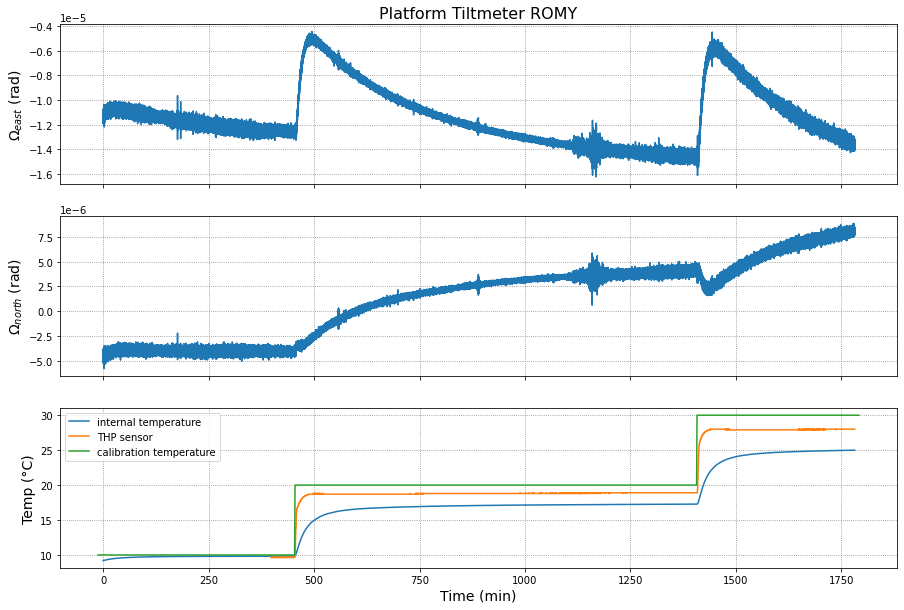

In [14]:
fig = __makeplot_data(st, tf, setT, config);

## Linear Regression

In [16]:
def __estimate_linear_trend(st, derive=None, smooth=None):
    
    temp = st[2].data
    
    if derive:
        temp = np.gradient(temp, 2)
        
    if smooth:
        temp = __smooth(temp, smooth)

    ## compute linear regression of data
    out1 = scipy.stats.linregress(temp, st[0].data)
    out2 = scipy.stats.linregress(temp, st[1].data)
    
    ## prepare output dictionary
    output = {}
    output['slope'] = [out1.slope, out2.slope]
    output['intercept'] = [out1.intercept, out2.intercept]
    
    return output

slopes: [2.1853601198245634e-06, 9.4984535971729651e-08] 
intercepts: [-3.4617366972785639e-05, -4.6112715923577762e-06]


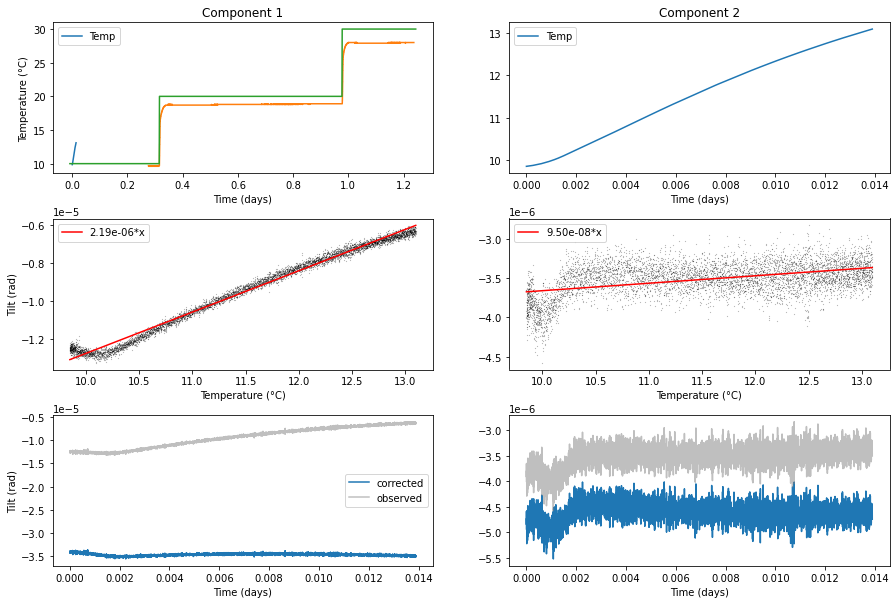

In [28]:
dat = st.copy()

dat = __remove_nan_values(dat)

dat.trim(UTCDateTime("2021-12-13 16:40"), UTCDateTime("2021-12-13 17:00"))

## define smoothing factor
smoothing = None

## compute linear regression 
out = __estimate_linear_trend(dat, derive=False, smooth=smoothing)

print(f"slopes: {out.get('slope')} \nintercepts: {out.get('intercept')}")

__makeplot_calibration(dat, out.get('slope'), out.get('intercept'), tf, setT=setT, derive=False, smooth=smoothing);

## Orthogonal Distance Regression

In [21]:
def __get_odr_estimate(st, std=[1, 1], derive=None, smooth=None):

    from scipy import odr

    def f(B, x):
        '''Linear function y = m*x + b'''
        return B[0]*x + B[1]
    
    output = {}
    output['slope'] = []
    output['intercept'] = []
    
    for i in range(2):
        
        y = st[i].data
        x = st[2].data

        if derive: 
            x = np.gradient(x, 2)
        
        if smooth:
            x = __smooth(x, smooth)
        
        sx = std[0]
        sy = std[1]

        linear = odr.Model(f)

        mydata = odr.Data(x, y, wd=1./np.power(sx,2), we=1./np.power(sy,2))

#         myodr = odr.ODR(mydata, linear, beta0=[1., 1.])
        myodr = odr.ODR(mydata, linear, beta0=[1e-8, 1e-8])

        myoutput = myodr.run()
        
        output['slope'].append(myoutput.beta[0])
        output['intercept'].append(myoutput.beta[1])
        
    return output

In [22]:
dat = st.copy()

dat = __remove_nan_values(dat)

## define smoothing factor
smoothing = None

## compute linear regression 
out = __get_odr_estimate(dat, std=[5e-6, 0.5], derive=False, smooth=smoothing)

print(f"slopes: {out.get('slope')} \nintercepts: {out.get('intercept')}")

__makeplot_compare(dat, out.get('slope'), out.get('intercept'), derive=False, smooth=smoothing);

slopes: [6.6299421422726889e-08, 7.0858538226703444e-07] 
intercepts: [-1.2472177291997757e-05, -1.0401926340576782e-05]


NameError: name '__makeplot_compare' is not defined

## Dump Correction Parameters

In [ ]:
# import yaml

# correction = {'Tiltmeter': config.get("tiltmeter"),
#               'correction': 'LongTermTrendTemperature',
#               'slopes':  {'C1': str(out.get('slope')[0]), 'C2': str(out.get('slope')[1])},
#               'intercepts':  {'C1': str(out.get('intercept')[0]), 'C2': str(out.get('intercept')[1])},
#              }

# filename = f"correction_longterm_{config.get('tiltmeter')}"

# if config['save']:
#     with open(f'{filename}.yml', 'w') as yaml_file:
#         yaml.dump(correction, yaml_file, default_flow_style=False)

## CrossCorrelation

In [ ]:
def __cross_correlation(y1, y2, norm=False, plot=True):
    """Calculates the cross correlation and lags.

    Args:
        y1, y2: Should have the same length.
        norm:   Boolean (False | True) for normalization 
    Returns:
        max_corr: Maximum correlation without normalization.
        lag: The lag in terms of the index.
    """
    
    from scipy.signal import correlate
    
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    ## calulate autocorrelation
    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    
    ## normalize input traces ?!
#     y1 /= np.max(abs(y1))
#     y2 /= np.max(abs(y2))
    
    ## calculate crorrelation function
    corr = correlate(y1, y2, mode='same')
    
    # The unbiased sample size is N - lag.
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')

    ## 
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    
    ## normalize
    if norm:
        corr /= np.max(abs(corr))
        
    ## calculate lag times 
    xlags = np.arange(-corr.size//2, corr.size//2, 1)

    ## get maximum    
#     corr_max_y = np.max(abs(corr))
    corr_max_x = np.argmax(abs(corr))-corr.size//2
    corr_max_y = corr[int(corr_max_x + corr.size//2)]
    
    
    shifted = np.roll(y2*corr_max_y, corr_max_x)

    
    ## Plotting
    if plot == True:
        fig, ax = plt.subplots(3, 1, figsize=(15,8))

        ax[0].plot(y1)

        ax[1].plot(y2)
        ax[1].plot(shifted)

        ax[2].plot(xlags, corr)

        ax[2].scatter(corr_max_x, corr_max_y, color='orange', zorder=3)
        ax[2].axvline(corr_max_x, color='k', ls=":")
        ax[2].axhline(corr_max_y, color='k', ls=":")

        for i in range(3):
            ax[i].grid(ls=":", zorder=1)
            
        plt.show();

    return corr, xlags, (corr_max_x, corr_max_y)

Creating data frames and removing linear/constant trend 

In [ ]:
# if config['tiltmeter'] == 'pt':
#     st = pt.copy()
# if config['tiltmeter'] == 'bt':
#     st = bt.copy()

# st = __remove_nan_values(st)

# ## create dataframe
# df_bt = pd.DataFrame({'c1':st[0].data, 
#                       'c2':st[1].data, 
#                       't': st[2].data
#                      })

# ## linear detrend
# detrend_type = 'constant' 
# df_bt.c1 = signal.detrend(df_bt.c1.values, type=detrend_type)
# df_bt.c2 = signal.detrend(df_bt.c2.values, type=detrend_type)
# df_bt.t  = signal.detrend(df_bt.t.values, type=detrend_type)    

# ## select component
# s0 = df_pt.c1
# s1 = df_pt.c2
# s2 = df_pt.t

# ## compute the derivative
# # s2 = np.gradient(s2, 2)

# ## smooth the derivative
# # s2 = __smooth(s2, 100)

# ## compute cross-correlation
# cc0, cc_lags0, cc_max0 = __cross_correlation(s0, s2 , norm=True)
# cc1, cc_lags1, cc_max1 = __cross_correlation(s1, s2 , norm=True)

# cc = [cc0, cc1]
# cc_lags = [cc_lags0, cc_lags1]
# cc_max = [cc_max0, cc_max1]

# print(f"Maximum Correltation for C1 at: \n x: {cc_max[0][0]} \n y: {cc_max[0][1]}")
# print(f"Maximum Correltation for C2 at: \n x: {cc_max[1][0]} \n y: {cc_max[1][1]}")